### Ignorar:

(mestrado guto):
**Propostas da Prof. Karin:**
- Treinar um modelo de classificação e tentar atingir o Tone, parecido com o que tem no artigo 
    - Gap Classificação: 
        1. Desempenho Ruim do Classificador (treinar "melhor")
        2. Desempenho ruim do fine-tuning por LLM
- Implementar um método (fine tuning / eng. de prompt) que faça a tarefa de reescrita (empática/polite)
    - Pode ter um gap aqui
- Treinar um modelo pra identificar motivos das reviews (Agrupamentos)

In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install --upgrade numpy
# %pip install seaborn
# %pip install scikit-learn
# %pip install tensorflow
# %pip install ipywidgets
# %pip install --upgrade gensim

%matplotlib inline

from IPython.display import clear_output

# clear_output()

---

### Inicio

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import re
from transformers import pipeline, AutoTokenizer, AutoModel
from keras.layers import TextVectorization
from keras.layers import Embedding
from gensim import utils
import gensim.models

### Dataframe:

In [4]:
path = 'PolitenessDataset-FULL.csv'

PolitenessDF = pd.read_csv(path)
print('Data Stats:', PolitenessDF.describe())
PolitenessDF.head(10)

Data Stats:               Tone
count  2500.000000
mean      2.867200
std       0.948854
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000


,Venue,Review ID,review,Tone,Review URL
0,ShitMyReviewerSay,NaN,"It is early in the year, but difficult to imag...",2,NaN
1,ShitMyReviewerSay,NaN,You do not use the empirical data for the anal...,2,NaN
2,ShitMyReviewerSay,NaN,I understand that Wikipedia is not the best so...,3,NaN
3,ShitMyReviewerSay,NaN,Reviewer #1: 'The project can hardly be descri...,3,NaN
4,ShitMyReviewerSay,NaN,The figures are dishonest and not all that use...,2,NaN
5,ShitMyReviewerSay,NaN,Find your inner nerdâ€”it must be a big part o...,1,NaN
6,ShitMyReviewerSay,NaN,[entire review] 'Research method is very impor...,4,NaN
7,ShitMyReviewerSay,NaN,Some papers are a pleasure to read. This is no...,2,NaN
8,ShitMyReviewerSay,NaN,"Sorry guys, I'm throwing in the towel.",1,NaN
9,ShitMyReviewerSay,NaN,Nobody in their right mind would ever suggest ...,2,NaN


In [6]:
# codificação
test = PolitenessDF.copy()

# codificação
test['CodeVenue'] = test['Venue'].astype('category').cat.codes

# train test split
X_train, X_test, y_train, y_test = train_test_split(test[['review','Tone']], test['Tone'], test_size=0.2, random_state=42)

max_length = X_train['review'].str.len().max()
print(f"The maximum length of characters is: {max_length}")

# Lengths of each review
lengths = X_train['review'].dropna().astype(str).str.len()

The maximum length of characters is: 552.0


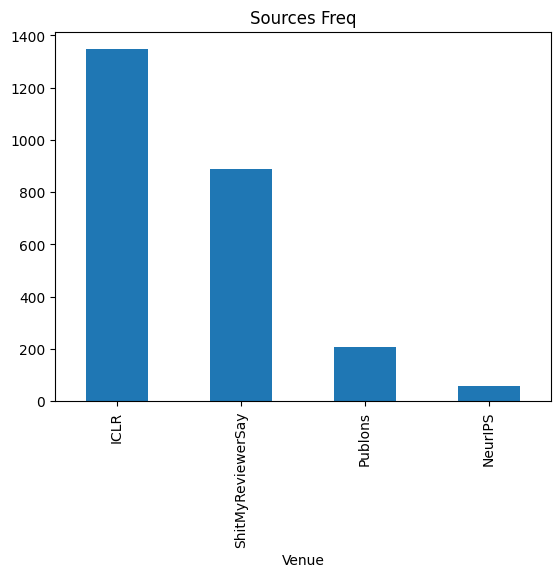

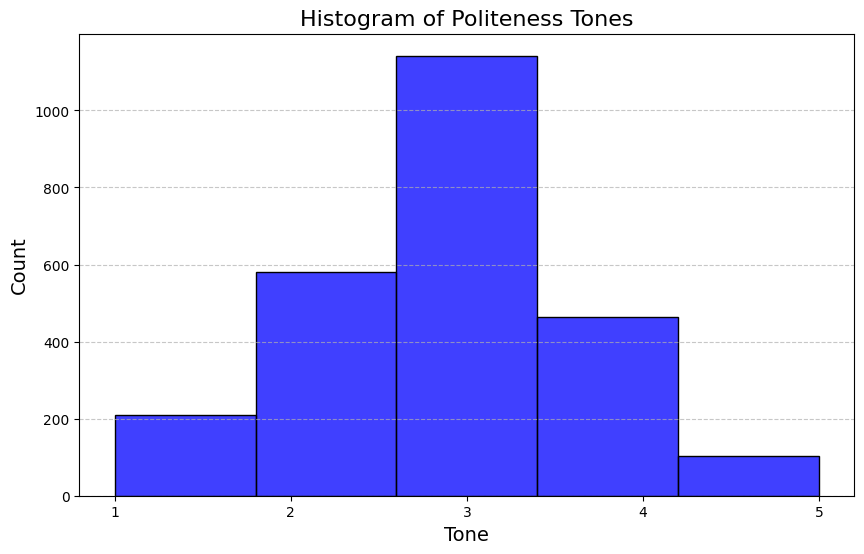

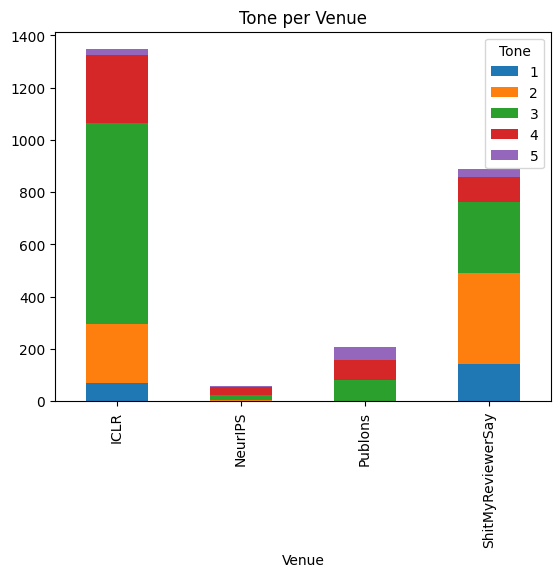

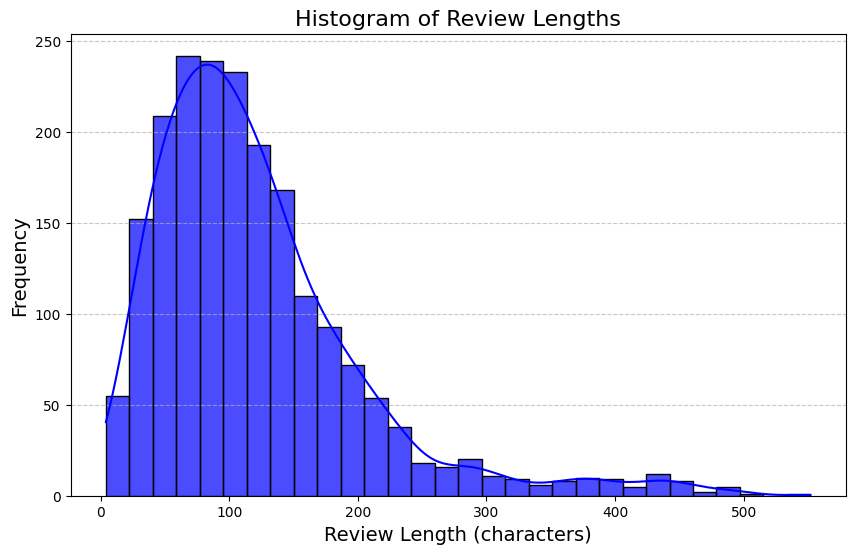

In [7]:
# Some visuals

# Plotting the distribution of the sources
PolitenessDF['Venue'].value_counts().plot(title='Sources Freq', kind='bar')
plt.show()

# Tone distribution
plt.figure(figsize=(10, 6))
sns.histplot(PolitenessDF['Tone'], bins=5, fill=True, color='blue', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=[1, 2, 3, 4, 5])
plt.title("Histogram of Politeness Tones", fontsize=16)
plt.xlabel("Tone", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

# Plot tone per venue, stacked
PolitenessDF.groupby(['Venue', 'Tone']).size().unstack().plot(kind='bar', stacked=True, title='Tone per Venue')
plt.show()

# Plot histogram of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True, color='blue', alpha=0.7)  # Seaborn for enhanced visuals
plt.title("Histogram of Review Lengths", fontsize=16)
plt.xlabel("Review Length (characters)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



### Pre-Processing

In [8]:
print('Special Characters:', punctuation)

# stop_words = stopwords.words('portuguese')
def preprocess(x: str):
    new_x = x.replace(r'"',' ')
    for c in punctuation:
        new_x = new_x.replace(c,' ')
    pattern = r"""
    [^\w\s]|         # Remove punctuation
    http\S+|         # Remove links
    @\w+|            # Remove mentions
    #\S+|            # Remove hashtags
    \b\w*\d\w*\b|    # Remove words containing numbers
    \s+              # Normalize spaces
    """    
    new_x = re.sub(pattern, ' ', new_x, flags=re.VERBOSE) #removendo pontuação do texto
    return new_x.lower().strip()

df_train = X_train.dropna().copy()
df_test = X_test.dropna().copy()

## Pré-processar datasets de treino e teste
## Dados de treino
df_train['review_original'] = df_train['review']
df_train['review'] = df_train['review'].apply(preprocess)

## Dados de teste
df_test['review_original'] = df_test['review']
df_test['review'] = df_test['review'].apply(preprocess)

Special Characters: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [9]:
## Samples (só para ver o processo mesmo)
df_train[df_train['Tone'] == 5].sample(1)['review_original'].values[0]

"Thanks for addressing the reviewers' recommendation."

In [10]:
## classe para montar o dataset
class PreProcess:
    def __init__(self, docs):
            self.lista_text = docs
    def __iter__(self):
        for line in self.lista_text:
            # assume there's one document per line, tokens separated by whitespace:
            yield utils.simple_preprocess(line) # este método tokeniza e faz algum preprocessamento
            # https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html

sentences = PreProcess(df_train['review'].values)
# assim treina o modelo usando as configurações padrão e estas especificadas aqui
ModelWord2Vec = gensim.models.Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, epochs=20, sg=1)

ModelWord2Vec

In [11]:
# adapta:
MAX_LENGHT = 552
vectorizer = TextVectorization(
    max_tokens=20000, #vocabulário maximo
    output_sequence_length=MAX_LENGHT,
    )

vectorizer.adapt(df_train['review'].dropna().astype(str).to_list())
voc = vectorizer.get_vocabulary()
print('Vocabulário novo:',len(voc))
clean_voc = [str(word) for word in voc] 

# agora vemos os tokens do dataset começando pelos mais frequentes:
print(f'Vocabulário tem {len(voc)} tokens. Os primeiros 5 tokens são:')
voc[:5]

Vocabulário novo: 4857
Vocabulário tem 4857 tokens. Os primeiros 5 tokens são:


['', '[UNK]', 'the', 'is', 'of']

In [12]:
len(clean_voc)

4857

In [13]:
# um dicionario com todas as palavras do vocabulario e seus indices de 0 a len(voc)-1
word_index = dict(zip(clean_voc, range(len(clean_voc))))
word_index

{'': 0,
 '[UNK]': 1,
 'the': 2,
 'is': 3,
 'of': 4,
 'to': 5,
 'a': 6,
 'and': 7,
 'in': 8,
 'this': 9,
 'i': 10,
 'paper': 11,
 'it': 12,
 'that': 13,
 'not': 14,
 'for': 15,
 'be': 16,
 'are': 17,
 'on': 18,
 'authors': 19,
 'with': 20,
 'have': 21,
 'as': 22,
 'but': 23,
 'would': 24,
 'an': 25,
 'there': 26,
 'or': 27,
 'work': 28,
 'you': 29,
 'more': 30,
 'by': 31,
 'some': 32,
 'results': 33,
 'very': 34,
 'can': 35,
 'from': 36,
 'my': 37,
 'what': 38,
 'they': 39,
 'manuscript': 40,
 'well': 41,
 'if': 42,
 'which': 43,
 'should': 44,
 'no': 45,
 'proposed': 46,
 'also': 47,
 'do': 48,
 'all': 49,
 'like': 50,
 'interesting': 51,
 'was': 52,
 'data': 53,
 'at': 54,
 'model': 55,
 'comments': 56,
 'so': 57,
 'does': 58,
 'has': 59,
 't': 60,
 'see': 61,
 'how': 62,
 'one': 63,
 'method': 64,
 'clear': 65,
 'seems': 66,
 'your': 67,
 'could': 68,
 'written': 69,
 'these': 70,
 'their': 71,
 'its': 72,
 'than': 73,
 'other': 74,
 'however': 75,
 'problem': 76,
 'why': 77,
 'secti

In [14]:
### HYPERPARAMETERS (from notebooks)
POLITENESS_LEVELS = 5
EPOCHS = 30
MAXLEN = 768 # Since SciBERT returns 768 embeddings vector
LSTM_UNITS = 256
is_BiLSTM = True # Flag to automate other pre-processing for With or Without BiLSTM variants
VOCAB_LEN = 1853
EMBEDDING_DIMENSION = 768

import pickle

# LOAD EMBEDS DATASET
def loadPickle(name):
    start_path = '../PolitePEER/'
    if is_BiLSTM:
        LOAD_PATH = start_path+'Tokennized_Processed_X_train-BiLSTM.csv'
        train_embeds = pd.read_csv(LOAD_PATH)
        
        LOAD_PATH = start_path+'Tokennized_Processed_X_test-BiLSTM.csv'
        test_embeds = pd.read_csv(LOAD_PATH)
        
        LOAD_PATH = start_path+'Tokennized_Processed_X_val-BiLSTM.csv'
        val_embeds = pd.read_csv(LOAD_PATH)
        
    else:
        LOAD_PATH = start_path+name+'_train.pickle'
        with open(LOAD_PATH, 'rb') as handle:
            train_embeds = pickle.load(handle)
            handle.close()

        LOAD_PATH = start_path+name+'_test.pickle'
        with open(LOAD_PATH, 'rb') as handle:
            test_embeds = pickle.load(handle)
            handle.close()

        LOAD_PATH = start_path+name+'_val.pickle'
        with open(LOAD_PATH, 'rb') as handle:
            val_embeds = pickle.load(handle)
            handle.close()

    y_train = pd.read_csv(start_path+'y_train.csv')
    y_val = pd.read_csv(start_path+'y_val.csv')
    y_test = pd.read_csv(start_path+'y_test.csv')

    print('\n***** LOADED '+ name+' *****\n')
    print(f'TRAIN SHAPE : {train_embeds.shape}\nTEST SHAPE : {test_embeds.shape}\nVAL SHAPE : {val_embeds.shape}\nY-TRAIN SHAPE : {y_train.shape}\nY-TEST SHAPE : {y_test.shape}\nY-VAL SHAPE : {y_val.shape}')

    return train_embeds, test_embeds, val_embeds, y_train, y_test, y_val

# /kaggle/input/iitpolitenesslevels/SCIBERT_train.pickle

In [15]:
name = ''
train_embeds, test_embeds, val_embeds, y_train, y_test, y_val = loadPickle(name)


***** LOADED  *****

TRAIN SHAPE : (4556, 768)
TEST SHAPE : (855, 768)
VAL SHAPE : (284, 768)
Y-TRAIN SHAPE : (4556, 5)
Y-TEST SHAPE : (855, 5)
Y-VAL SHAPE : (284, 5)


<span style="color:#e687f1;">**TODO**</span>: continuar daqui

GPT suggestions, embeddings:

Summary of Options:
- BERT (Hugging Face): Contextual, state-of-the-art embeddings but computationally heavier.
- GloVe/FastText: Simpler, pre-trained embeddings that are non-contextual but lightweight.


In [ ]:
%pip install transformers

from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def encode_reviews(reviews):
    encoded_inputs = tokenizer(
        reviews.tolist(),  # Convert Series to list
        padding=True,      # Pad to max length in batch
        truncation=True,   # Truncate longer sequences
        return_tensors="pt"  # Return PyTorch tensors
    )
    return encoded_inputs

def encode_reviews(reviews):
    encoded_inputs = tokenizer(
        reviews.tolist(),  # Convert Series to list
        padding=True,      # Pad to max length in batch
        truncation=True,   # Truncate longer sequences
        return_tensors="pt"  # Return PyTorch tensors
    )
    return encoded_inputs

def get_bert_embeddings(encoded_inputs):
    with torch.no_grad():
        outputs = bert_model(**encoded_inputs)
    return outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_dim)




#############################--------------------------------------------------------
## Alternative 2: GloVe or FastText Pre-trained Embeddings
'''
If you want lighter embeddings, GloVe or FastText can be good alternatives. These are non-contextual but computationally efficient.

Steps to Implement GloVe Embeddings:
Download Pre-trained GloVe: Download GloVe vectors (e.g., glove.6B.300d.txt) from GloVe.
'''
import numpy as np

def load_glove_embeddings(filepath, embedding_dim=300):
    embedding_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embedding_index[word] = vector
    return embedding_index

def create_embedding_matrix(vocab, embedding_index, embedding_dim):
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[idx] = vector
    return embedding_matrix

def create_embedding_matrix(vocab, embedding_index, embedding_dim):
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[idx] = vector
    return embedding_matrix


## Descomentar aqui

# import torch.nn as nn

# vocab_size, embedding_dim = embedding_matrix.shape
# embedding_layer = nn.Embedding.from_pretrained(
#     torch.FloatTensor(embedding_matrix)
# )